# Project 1: Finding Lane Lines

## Goal:
The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.


<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Approach(Pipeline)
### description
A pipline is designed to achive the lane detection goal with the following methods:
1. grayscale: convert the image to grayscale image 
2. gaussian_blur: reduce image noise
3. canny: using the gradient to find the edges of the objects in the image 
4. region of interest: as the camera location is fixed, a region that lane will appear can be defined 
5. hough_lines. use the hough transformation to find the lines 
6. interpolate. the line segments,represented by points,are divided into two groups using the centerline of the image. Those points with x-coordinates smaller than 1/2*image_width are assigned into one group, the ones with x-coordinates greater than 1/2*image_width are assigned into the other group. Two linear regressions are performed on two point groups respectively. With the regression line, the lane can be predicted using the boundary coordinates defined in the region of interest. 
7. weighted_img. draw the interpolated line and the original image together with given weights.


### Code


In [6]:
import numpy as np
import cv2
from sklearn import linear_model

class lane_help():
    def __init__(self):
        pass

    def grayscale(self,input_image):
        '''
        apply grey tansform
        '''
        self.image = input_image
        self.after_gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        return self.after_gray
    
    def gaussian_blur(self, kernel_size):
        '''
        Applies a Gaussian Noise kernel
        '''
        self.after_blur = cv2.GaussianBlur(self.after_gray, (kernel_size, kernel_size), 0)
        return self.after_blur    
    
    def canny(self, low_threshold, high_threshold):
        '''
        Applies the Canny transform
        '''
        self.edges = cv2.Canny(self.after_blur, low_threshold, high_threshold)
        return self.edges
    
    def region_of_interest(self, vertices):
        '''
        apply image mask 
        vertices are arrays of tuples, the array can be unsorted 
        '''
        # sort the array by its x coordinates 
        sorted(vertices, key = lambda each: each[0])
        mask = np.zeros_like(self.edges)
        ignore_mask_color = 255
        vertices = np.array([vertices])
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        self.masked_edges = cv2.bitwise_and(self.edges, mask)
        return self.masked_edges
     
    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.
            
        Returns an image with hough lines drawn.
        """
        img = self.masked_edges
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        self.lines = lines
    
    def interpolate(self, start_ratio):
        lines = self.lines
        line_img = np.copy(self.image)*0
        (image_height, image_width, _) = self.image.shape
        center_line = image_width/2
#        linear regression for the lane interpolation
        right_x= []
        right_y= []
        right_line = linear_model.LinearRegression()
        left_x = []
        left_y = []
        left_line = linear_model.LinearRegression()
#        for line in lines:
#            for x1,y1,x2,y2 in line:
#                cv2.line(line_img, (x1,y1), (x2,y2),(255,0,0),5)
        for line in lines:
            [[x1,y1,x2,y2]] = line
#            seperate the points into left and right groups 
            if (x2 < center_line):
                right_x.extend([x1,x2])
                right_y.extend([y1,y2])
            else:
                left_x.extend([x1,x2])
                left_y.extend([y1,y2])
        right_x = np.transpose(np.matrix(right_x))
        right_y = np.transpose(np.matrix(right_y))
        left_x = np.transpose(np.matrix(left_x))
        left_y = np.transpose(np.matrix(left_y))
        
        right_line.fit(right_x,right_y) 
        left_line.fit(left_x,left_y)
#        total 4 points, 2 left, 2 right 
        right_bot_x = int(image_width/start_ratio)
        right_bot_y = int(right_line.predict(image_width/start_ratio))
        right_top_x = int(1/2 * image_width)
        right_top_y = int(right_line.predict(1/2 * image_width))
        left_bot_x = int(image_width/start_ratio * (start_ratio-1))
        left_bot_y = int(left_line.predict(image_width/start_ratio * (start_ratio-1)))
        left_top_x = int(1/2 * image_width)
        left_top_y = int(left_line.predict(1/2 * image_width))
#        draw the line
        cv2.line(line_img,(right_top_x,right_top_y),
                 (right_bot_x,right_bot_y),(255,0,0),12)
        cv2.line(line_img, (left_bot_x,left_bot_y),
                 (left_top_x,left_top_y), (255,0,0),12)
        self.line_img = line_img
            
    
    def weighted_img(self, alpha=0.8, beta=1., omega=0):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.
        
        `initial_img` should be the image before any processing.
        
        The result image is computed as follows:
        
        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        lines_edges = cv2.addWeighted(self.line_img, alpha, self.image, beta, 0) 
        return lines_edges

### Testing 
The pipeline is tested with given example pictures as shown below:

<IPython.core.display.Javascript object>


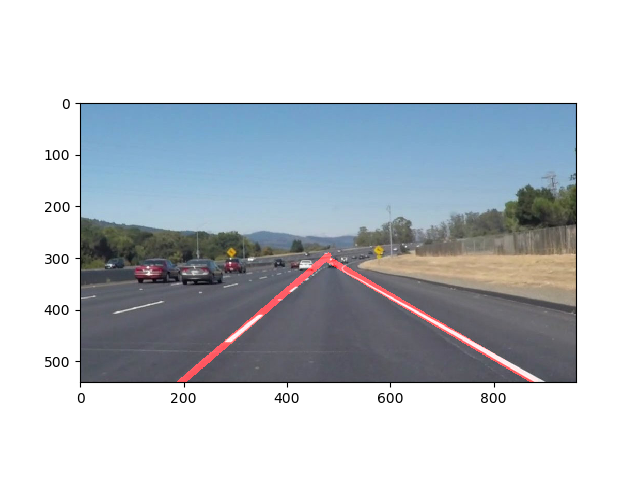

<IPython.core.display.Javascript object>


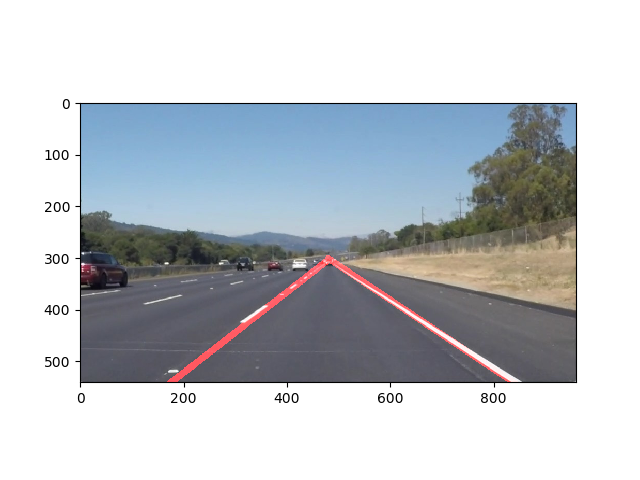

<IPython.core.display.Javascript object>


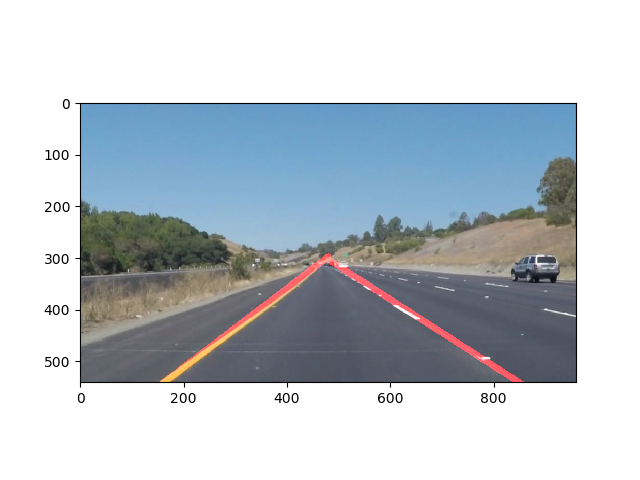

<IPython.core.display.Javascript object>


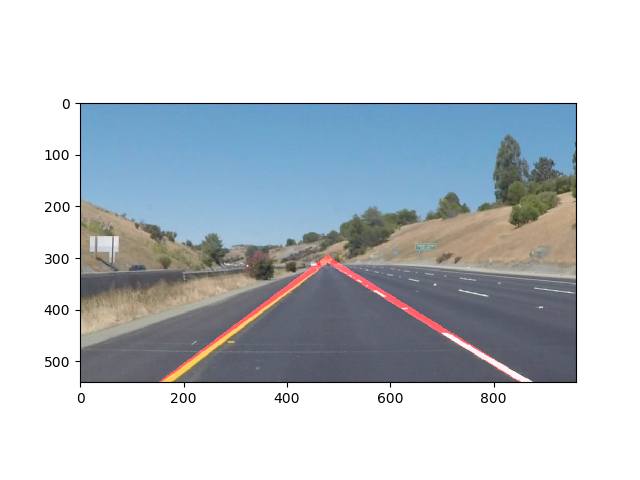

<IPython.core.display.Javascript object>


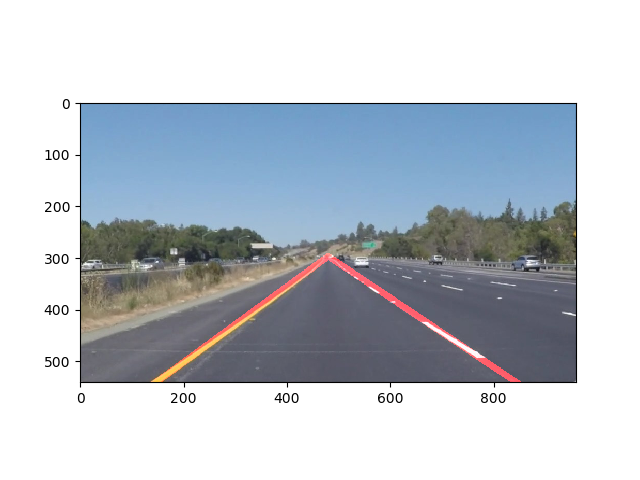

<IPython.core.display.Javascript object>


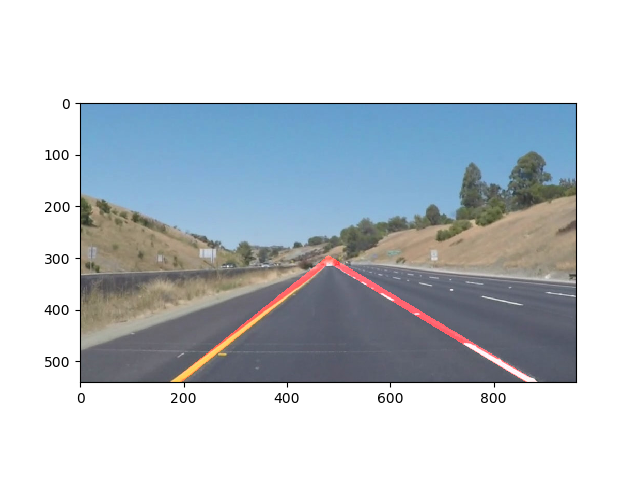

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
from lane_helper import lane_help
import os

def find_lane(input_image,bot_ratio=12,rho=1,theta=np.pi/180, threshold=5, min_line_len=2, max_line_gap=1):
    '''
    use the lane_help object to find the lane
    '''
    lane_detect = lane_help()
    lane_detect.grayscale(input_image)
    lane_detect.gaussian_blur(5)
    lane_detect.canny(50,100)
#    find the target image
#    Assumption: a trangle region with bottom of 3/4 image length 
#    height of half of the image height located at the center of the image 
    (image_height, image_width, _) = input_image.shape
    x_left_bot, x_right_bot, x_top = int(image_width/bot_ratio), int((bot_ratio-1)*image_width/bot_ratio), int(image_width/2)
    y_bot, y_top = image_height, int(image_height/2*1.05)
    INTEREST_REGION_TEST = [(x_left_bot, y_bot),(x_right_bot, y_bot),(x_top, y_top)]
    lane_detect.region_of_interest(INTEREST_REGION_TEST)
    lane_detect.hough_lines(rho, theta, threshold, min_line_len, max_line_gap)
    lane_detect.interpolate(12)
    image = lane_detect.weighted_img()
    return image
# test image address 
all_image_address = ["test_images/" + each_address for each_address in os.listdir("test_images/")]

# check the function by ploting 
result_image = []
idx = 0
for each in all_image_address:
    each_image = mpimg.imread(each)
    result_image.append(find_lane(each_image,12))
    plt.figure(idx)
    plt.imshow(result_image[-1])
    idx += 1

### Apply pipeline on videos

In [11]:
from moviepy.editor import VideoFileClip
# video 01
white_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(find_lane)
white_clip.write_videofile(white_output, audio=False)
#video 02
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_lane)
white_clip.write_videofile(white_output, audio=False)
# challenge video
white_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(find_lane)
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:13<00:00, 49.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:04<00:00, 51.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████| 251/251 [00:10<00:00, 24.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



### Evaluation
The video processed using the designed pipeline successfully generates expected result with lanes clearly marked by straight red lines.
For the challenge video, although the mark line does not mark the lane as precisely as in the other two videos, it still produce a reasonable result, as shown in the generated video, challenge_result.mp4. The tree shadow affect the recognition significantly. In addition, the interests region in the challenge video is different than the other two video, with the different interest region, the result can be improved.
